In [113]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [114]:
import ipyparallel as ipp

cluster = ipp.Client()

v = cluster[:]
lview = cluster.load_balanced_view()
len(v)

100

In [115]:
import os

os.environ["OMP_NUM_THREADS"] = "1" # export OMP_NUM_THREADS=1
os.environ["OPENBLAS_NUM_THREADS"] = "1" # export OPENBLAS_NUM_THREADS=1 
os.environ["MKL_NUM_THREADS"] = "1" # export MKL_NUM_THREADS=1                              #Block multithreading
os.environ["VECLIB_MAXIMUM_THREADS"] = "1" # export VECLIB_MAXIMUM_THREADS=1
os.environ["NUMEXPR_NUM_THREADS"] = "1" # export NUMEXPR_NUM_THREADS=1

In [116]:
%%px --local

import kwant
import tinyarray
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import scipy.linalg as la
import numpy as np
from numpy import linalg as LA
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [117]:
%%px --local

from cmath import exp
from math import pi
# Pauli matrices
import scipy.constants as sc
from scipy.constants import physical_constants
from scipy import constants
from types import SimpleNamespace
plt.rcParams.update({'font.size': 16})

In [118]:
%%px --local

tau_0 = tinyarray.array([[1, 0], [0, 1]])
tau_x = tinyarray.array([[0, 1], [1, 0]])
tau_y = tinyarray.array([[0, -1j], [1j, 0]])
tau_z = tinyarray.array([[1, 0], [0, -1]])
taux1 = tinyarray.array([[0, 1], [0, 0]])
taux2 = tinyarray.array([[0, 0], [1, 0]])

In [119]:
%%px --local

m_e = physical_constants['electron mass'][0]
eV = physical_constants['electron volt'][0]
hbar = physical_constants['reduced Planck constant'][0]
e_hbar = physical_constants['elementary charge over h-bar'][0]

In [120]:
%%px --local
# We have created the same system but with a one function
def make_system(L_N,W):
    #CREATE SYSTEM
    #W=100
    a = 5*1e-9
    m = sc.m_e*0.014
    t = (sc.hbar**2/(2*m*a**2))/sc.eV
    
    lat = kwant.lattice.square(a*1e9, norbs=1)
    syst = kwant.Builder()
   
    
    def system(pos):                # This is the Normal part       
        (x,y) = pos
        ret = False
        if (0 <= x <= L_N and 0 <= y <= W):
            ret = True
        return ret
    
    
    B_field_temp = 0#1e-10
    
    def onsite(site, mu):
        (x, y) = site.pos
        return  (4 * t - mu) 
    
    def hop_x(site1, site2):
        return -t
    
    def hop_y(site1,site2):
        return -t 
       
    syst[lat.shape(system, (0,0))] = onsite
    #syst[lat.neighbors()] = hop_system #-t * tau_z
    syst[kwant.builder.HoppingKind((1, 0), lat, lat)] = hop_x
    syst[kwant.builder.HoppingKind((0, 1), lat, lat)] = hop_y

    def lead_shape(pos):
        (x, y) = pos
        ret = False
        if 0 <= y <= W:
            ret=True
        return ret
    
    def lead_top_shape(pos):
        (x, y) = pos
        ret = False
        if 0 <= x <= L_N:
            ret=True
        return ret
   
    def left_onsite(site, mu):
        return (4 * t - mu)
    
    def right_onsite(site, mu):

        return  (4 * t - mu)
    
    def top_onsite(site, mu):
        return (4 * t - mu)
    
    
    def hop_lead_x(site1 ,site2):
        return -t
    
    def hop_lead_y(site1, site2):
        return -t 
   

    # Now we go to define the leads
    # Left lead - normal, so the order parameter is zero
    dx =a*1e9
   
    lead_left = kwant.Builder(kwant.TranslationalSymmetry((-dx, 0)), time_reversal= 1)
    lead_left[lat.shape(lead_shape, (0, 0))]  = left_onsite
    #lead_left[lat.neighbors()] = hop_lead
    lead_left[kwant.builder.HoppingKind((1, 0), lat, lat)] = hop_lead_x
    lead_left[kwant.builder.HoppingKind((0, 1), lat, lat)] = hop_lead_y
    

    lead_right = kwant.Builder(kwant.TranslationalSymmetry((dx, 0)), time_reversal= 1)
    lead_right[lat.shape(lead_shape, (0, 0))]  = right_onsite
    #lead_right[lat.neighbors()] = hop_lead
    lead_right[kwant.builder.HoppingKind((1, 0), lat, lat)] = hop_lead_x
    lead_right[kwant.builder.HoppingKind((0, 1), lat, lat)] = hop_lead_y
    
    
    lead_top = kwant.Builder(kwant.TranslationalSymmetry((0, dx)), time_reversal= 1)
    lead_top[lat.shape(lead_top_shape, (0, 0))]  = top_onsite
    #lead_top[lat.neighbors()] = hop_lead
    lead_top[kwant.builder.HoppingKind((1, 0), lat, lat)] = hop_lead_x
    lead_top[kwant.builder.HoppingKind((0, 1), lat, lat)] = hop_lead_y
     
    syst.attach_lead(lead_left)
    syst.attach_lead(lead_right)
    syst.attach_lead(lead_top)
 
    syst = syst.finalized()

        
    return syst

In [121]:
def ABS(smatrix, Delta, phi1, phi2, phi3):
    s = smatrix
    N, M, L = [len(li.momenta) // 2 for li in s.lead_info]
    s = s.data
    
    #print("Shape of the scattering matrix:", np.shape(s))
    
    r_a11 = 1j * np.exp(-1j * phi1) * np.eye(N)
    r_a12 = np.zeros((N, M))
    r_a13 = np.zeros((N, L))

    r_a21 = r_a12.T
    r_a22 = 1j * np.exp(-1j * phi2) * np.eye(M)
    r_a23 = np.zeros((M,L))
    
    r_a31 = r_a13.T
    r_a32 = r_a23.T
    r_a33 = 1j * np.exp(-1j * phi3) * np.eye(L) 
    
    r_a = np.bmat([[r_a11, r_a12, r_a13], [r_a21, r_a22, r_a23],[r_a31, r_a32, r_a33]])
    zeros = np.zeros(shape=(len(s), len(s)))
    matrix = np.bmat([[zeros, (s.T.conj()).dot(r_a.conj())],
                      [(s.T).dot(r_a), zeros]])

    eigVl, eigVc  = la.eig(matrix)
    #eigVc = la.qr(eigVc)[0]
    eigVlinds = eigVl.argsort()
    eigVl = eigVl[eigVlinds]
    eigVc = eigVc[:,eigVlinds]
        
#     values = eigVl[eigVl.real > 0].real        
#     #values = values[0::2]
#     valores = values[0::2]
    
#     vectors=[]
# #     for ii in range(len(values)):
# #         if eigVl[ii].real > 0:
# #             vectors.append(eigVc[ii].T[0:len(eigVl)//2] )
            
#     for ii in range(len(values)):
#         vectors.append(eigVc[ii].T[0:len(eigVl)//2] )
        
    
    eigenvalues = []
    eigenvectors_e = []
    eigenvectors_h = []
    
    for iv, value in enumerate(eigVl):
        if (value.real > 0):
            eigenvalues.append(value.real)
            eigenvectors_e.append(eigVc.T[iv][0:len(eigVl)//2])
            eigenvectors_h.append(eigVc.T[iv][len(eigVl) // 2:len(eigVl)])
            
    eigenvalues = eigenvalues[::2]
    eigenvectors_e = eigenvectors_e[::2]
    eigenvectors_h = eigenvectors_h[::2]

    return np.array(eigenvalues)*Delta,eigenvectors_e, eigenvectors_h

In [122]:
%%px --local

import scipy.optimize as sco 
from scipy.optimize import minimize, rosen, rosen_der, rosen_hess, shgo
from scipy.optimize import minimize_scalar
from scipy.optimize import basinhopping,brute,dual_annealing
from scipy.optimize import Bounds
from scipy.optimize import rosen, differential_evolution

def efficiency_phase3(x,L_N,W):
    #x = params[0]
    syst = make_system(L_N =L_N, W=W)
    smatrix = kwant.smatrix(syst, energy=0, params=dict(mu = 10*1e-3))
    ABStab= []
    phase2= np.linspace(0, 2 * pi, 100)
    Delta=0.2*1e-3
    for phi2 in phase2:
        ABStab.append(sum(ABS(smatrix=smatrix, Delta=0.2*1e-3, phi1 = 0, phi2 = phi2, phi3=x)[0]))
   
    I= -1*np.gradient(ABStab, phase2)#current is -1* derivative d ABS/ d phi
    

    maximum =  (max(I)/Delta)
    minimum =  (min(I)/Delta)

    
    #n = (maximum - abs(minimum))/(maximum + abs(minimum))
    n = abs(maximum - abs(minimum))/(maximum + abs(minimum))

    return -n*100

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution
from itertools import product
from ipyparallel import Client

# Function to perform optimization for a given set of parameters
def optimize_for_parameters(params):
    L_N, W = params

    # Define the bounds for the unknown parameter
    bounds = [(0, 2*np.pi)]  # Example: the unknown parameter is between 0 and 2*pi

    # Run differential evolution
    result = differential_evolution(efficiency_phase3, bounds, args=(L_N, W))
    #if result.x[0] < np.pi:
        #result.fun = -result.fun

    # Return the result
    return L_N, W, result.x[0], abs(result.fun)

# Set up an IPython parallel client
# rc = Client()
# lview = rc.load_balanced_view()

# Use linspace to generate values for L_N and W
L_N_values = W_values = np.linspace(50, 300, 50)

# Create all combinations of L_N and W using itertools.product
parameter_sets = list(product(L_N_values, W_values))

# Use lview.map_async for parallel execution
result_async = lview.map_async(optimize_for_parameters, parameter_sets)

# Wait for the results
result_async.wait_interactive()
result_list = result_async.get()

# Extract optimal values for plotting
optimal_values_efficiency_absolutos = [result[3] for result in result_list]
optimal_values_phases3_absolutos = [result[2] for result in result_list]


# Reshape the optimal_values into a 2D array for plotting
optimal_array_efficiency_absolutos = np.array(optimal_values_efficiency_absolutos).reshape(len(L_N_values), len(W_values))
optimal_array_phases3_absolutos = np.array(optimal_values_phases3_absolutos).reshape(len(L_N_values), len(W_values))

 963/2500 tasks finished after 3447 s

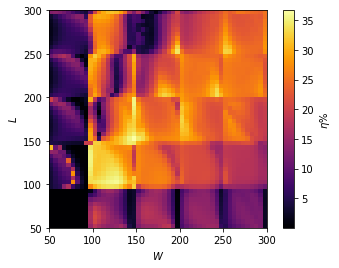

In [88]:
# Plot the colormap with colorbar
plt.imshow(optimal_array_efficiency_absolutos, extent = [50,300,50,300], origin='lower', cmap='inferno')
cbar = plt.colorbar(label='$\eta \%$')
plt.xlabel('$W$')
plt.ylabel('$L$')
#plt.title('Colormap of Optimal Function Values')
plt.savefig("colormap_efficiency_optimized_absolutos.pdf", bbox_inches ="tight")
plt.show()

In [138]:
import pandas as pd
optimal_array_efficiency_absolutos
pd.DataFrame(optimal_array_efficiency_absolutos).to_pickle('/home/jhcorrea/data_long_junction/map_efficiency_numericalshort.pkl')    #to save the dataframe, df to *.pkl\
